In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx


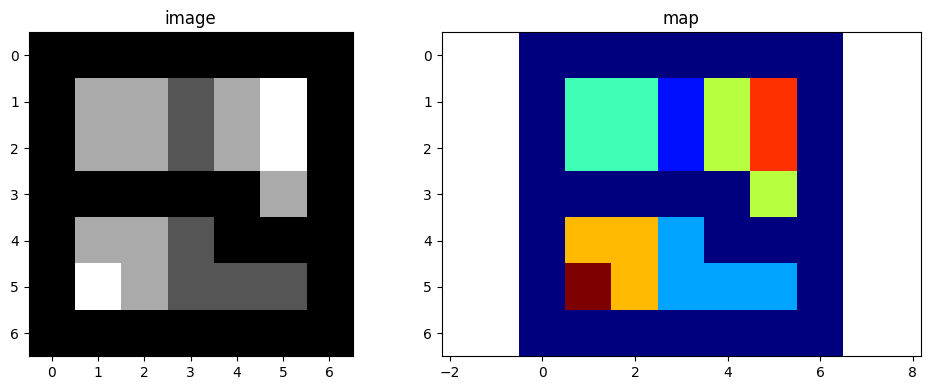


NodeTable:
  Name  Level                                             Pixels
0   c1      1  [1, 8, 15, 22, 29, 36, 43, 2, 44, 3, 45, 4, 11...
1   c2      2                                           [23, 24]
2   c3      2                                   [26, 27, 34, 41]
3   c4      3                                    [9, 16, 10, 17]
4   c5      3                                       [30, 31, 39]
5   c6      3                                       [12, 19, 20]
6   c7      4                                           [37, 38]
7   c8      4                                               [13]


/var/folders/f2/szdn4h555wv3xkj5npgb1nqc0000gn/T/ipykernel_30853/3939194047.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


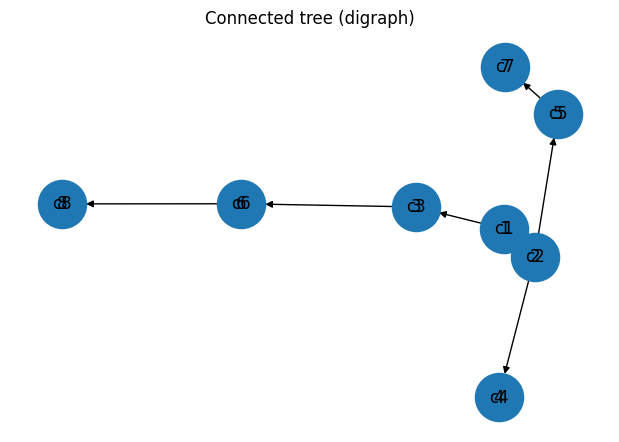


[v, level, diff(level)]
[[ 1  1  1]
 [ 2  2  1]
 [ 4  3  0]
 [ 5  3  1]
 [ 7  4 -2]
 [ 3  2  1]
 [ 6  3  1]
 [ 8  4  0]]

Indices where diff(level) < 0: [4]

Mpattern1: [2, 4, 5, 7] ['c2', 'c4', 'c5', 'c7']
Mpattern2: [3, 6, 8] ['c3', 'c6', 'c8']


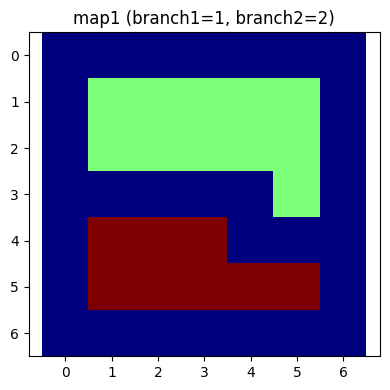


Shortest path 2 -> 7: [2, 5, 7] ['c2', 'c5', 'c7']


/var/folders/f2/szdn4h555wv3xkj5npgb1nqc0000gn/T/ipykernel_30853/3939194047.py:187: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


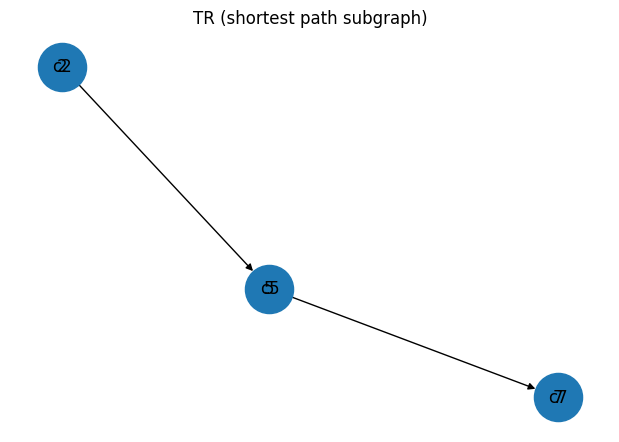

In [2]:

# ----------------------------
# 1) Build the 7x7 image + map
# ----------------------------
image = np.ones((7, 7), dtype=int)  # background = 1
mp = np.zeros((7, 7), dtype=int)    # pattern map

# MATLAB is 1-based; Python is 0-based -> subtract 1 from indices

# level 2 patterns
image[1:3, 3] = 2
mp[1:3, 3] = 2

image[5, 3:6] = 2
image[4, 3] = 2
mp[5, 3:6] = 3
mp[4, 3] = 3

# level 3 patterns
image[1:3, 1:3] = 3
mp[1:3, 1:3] = 4

image[1:3, 4] = 3
image[3, 5] = 3
mp[1:3, 4] = 5
mp[3, 5] = 5

image[4, 1:3] = 3
image[5, 2] = 3
mp[4, 1:3] = 6
mp[5, 2] = 6

# level 4 patterns
image[1:3, 5] = 4
mp[1:3, 5] = 7

image[5, 1] = 4
mp[5, 1] = 8

# background pixels -> map = 1 (like MATLAB)
mp[image == 1] = 1

# visualize image + map
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(image, cmap="gray", interpolation="nearest")
ax[0].set_title("image")
ax[0].axis("image")

ax[1].imshow(mp, cmap="jet", interpolation="nearest")
ax[1].set_title("map")
ax[1].axis("equal")
plt.tight_layout()
plt.show()

# -----------------------------------------
# 2) Build NodeTable (names, levels, pixels)
# -----------------------------------------
names = [f"c{i}" for i in range(1, 9)]
levels = [1, 2, 2, 3, 3, 3, 4, 4]

# MATLAB 'find' returns linear indices (column-major).
# We'll store BOTH:
# - MATLAB-style linear indices (1..49, col-major)
# - Python linear indices (0..48, row-major), if you ever need them
def matlab_linear_indices(mask_2d: np.ndarray) -> np.ndarray:
    # mask_2d is boolean shape (7,7)
    r, c = np.where(mask_2d)
    # MATLAB linear index (1-based), column-major:
    return (r + 1) + (c) * mask_2d.shape[0]

pixels_matlab = []
for i in range(1, 9):
    idx = matlab_linear_indices(mp == i).tolist()
    pixels_matlab.append(idx)

node_table = pd.DataFrame({
    "Name": names,
    "Level": levels,
    "Pixels": pixels_matlab
})
print("\nNodeTable:")
print(node_table)

# ----------------------------
# 3) Build directed graph (A)
# ----------------------------
A = np.zeros((8, 8), dtype=int)
A[0, 1] = 1  # c1->c2
A[0, 2] = 1  # c1->c3
A[1, 3] = 1  # c2->c4
A[1, 4] = 1  # c2->c5
A[4, 6] = 1  # c5->c7
A[2, 5] = 1  # c3->c6
A[5, 7] = 1  # c6->c8

G = nx.DiGraph()

# add nodes with attributes (like NodeTable)
for i in range(8):
    G.add_node(i+1, Name=names[i], Level=levels[i], Pixels=pixels_matlab[i])  # node ids 1..8

# add edges from adjacency matrix
for i in range(8):
    for j in range(8):
        if A[i, j] == 1:
            G.add_edge(i+1, j+1)

# plot graph
plt.figure(figsize=(6, 4))
pos = nx.spring_layout(G, seed=1)
nx.draw(G, pos, with_labels=True, node_size=1200, arrows=True)
nx.draw_networkx_labels(G, pos, labels={n: G.nodes[n]["Name"] for n in G.nodes})
plt.title("Connected tree (digraph)")
plt.tight_layout()
plt.show()

# ----------------------------
# 4) DFS order + split branches
# ----------------------------
v = list(nx.dfs_preorder_nodes(G, source=1))  # like dfsearch(G,1)
lev = np.array([G.nodes[n]["Level"] for n in v])

diff_lev = np.diff(lev)
print("\n[v, level, diff(level)]")
print(np.column_stack([v, lev, np.r_[diff_lev, 0]]))

# find where the level drops (diff < 0), like MATLAB
drop_idx = np.where(diff_lev < 0)[0]
print("\nIndices where diff(level) < 0:", drop_idx)

# In your MATLAB, you used v(2:id) and v(id+1:end).
# Here we mirror that using the first drop.
if len(drop_idx) == 0:
    raise RuntimeError("No level drop found; cannot split into two main branches.")
id0 = drop_idx[0]  # index in diff -> split point in v

# note: MATLAB starts from v(2), skipping root
Mpattern1 = v[1:id0+1]      # inclusive up to id0
Mpattern2 = v[id0+1:]       # rest

print("\nMpattern1:", Mpattern1, [G.nodes[n]["Name"] for n in Mpattern1])
print("Mpattern2:", Mpattern2, [G.nodes[n]["Name"] for n in Mpattern2])

# collect pixel lists (MATLAB-style linear indices)
Mp1_pixels = [p for n in Mpattern1 for p in G.nodes[n]["Pixels"]]
Mp2_pixels = [p for n in Mpattern2 for p in G.nodes[n]["Pixels"]]

# ---------------------------------------
# 5) Build map1: 1 for branch1, 2 for branch2
# ---------------------------------------
map1 = np.zeros((7, 7), dtype=int)

def matlab_lin_to_rc(lin: int, nrows: int) -> tuple[int, int]:
    # lin is 1-based column-major
    lin0 = lin - 1
    r = lin0 % nrows
    c = lin0 // nrows
    return r, c

for lin in Mp1_pixels:
    r, c = matlab_lin_to_rc(lin, 7)
    map1[r, c] = 1

for lin in Mp2_pixels:
    r, c = matlab_lin_to_rc(lin, 7)
    map1[r, c] = 2

plt.figure(figsize=(4, 4))
plt.imshow(map1, cmap="jet", interpolation="nearest")
plt.title("map1 (branch1=1, branch2=2)")
plt.axis("equal")
plt.tight_layout()
plt.show()

# ----------------------------
# 6) Shortest path 2 -> 7
# ----------------------------
TR_nodes = nx.shortest_path(G, source=2, target=7)
print("\nShortest path 2 -> 7:", TR_nodes, [G.nodes[n]["Name"] for n in TR_nodes])

TR = G.subgraph(TR_nodes).copy()

plt.figure(figsize=(6, 4))
pos2 = nx.spring_layout(TR, seed=1)
nx.draw(TR, pos2, with_labels=True, node_size=1200, arrows=True)
nx.draw_networkx_labels(TR, pos2, labels={n: G.nodes[n]["Name"] for n in TR.nodes})
plt.title("TR (shortest path subgraph)")
plt.tight_layout()
plt.show()
